# Understanding the impact of varying the batch size

We will compare the following:
- The loss and accuracy values of the training and validation data when the training batch size is 32
- the loss and accuravy values of the training and validation data when the training batch size is 10000

## Batch size of 32

1. Download and import the training set:

In [2]:
from torchvision import datasets
import torch
data_folder = "./data/FMNIST"
training_fmnist = datasets.FashionMNIST(data_folder, download=True, train=True)

training_images = training_fmnist.data
training_labels = training_fmnist.targets

2. In a similar manner to training images, we must download and import the validation dataset by specifying `train = False` while calling the `FashionMNIST` method in our datasets:

In [3]:
validation_fmnist = datasets.FashionMNIST(data_folder, download=True, train=False)

validation_images = validation_fmnist.data
validation_labels = validation_fmnist.targets

3. Import relevant packages and define `device`:

In [16]:
import matplotlib.pyplot as plt
from matplotlib import ticker
%matplotlib inline
plt.style.use(['science', 'notebook', 'grid'])

import numpy as np
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device: {device}")

Device: cuda


4. Define dataset class, and helper functions

In [5]:
class FMNISTDataset(Dataset):
    def __init__(self, x, y):
        x = x.float()/255
        x = x.view(-1, 28*28)
        self.x, self.y = x, y
        
    def __getitem__(self, idx):
        x, y = self.x[idx], self.y[idx]
        return x.to(device), y.to(device)

    def __len__(self):
        return len(self.x)


from torch.optim import SGD, Adam
def get_model(use_SGD=True, lr=1e-2):
    model = nn.Sequential(
        nn.Linear(28 * 28, 1000),
        nn.ReLU(),
        nn.Linear(1000, 10)
    ).to(device)

    loss_func = nn.CrossEntropyLoss()
    optimizer = SGD(model.parameters(), lr=lr) if use_SGD else Adam(model.parameters(), lr=lr)

    return model, loss_func, optimizer


def train_batch(x, y, model, loss_func, optimizer):
    model.train()
    prediction = model(x)
    batch_loss = loss_func(prediction, y)
    batch_loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    return batch_loss.item()

def accuracy(x, y, model):
    model.eval()
    with torch.no_grad():
        prediction = model(x)
    max_values, argmaxes = prediction.max(-1)
    is_correct = argmaxes == y
    return is_correct.cpu().numpy().tolist()

5. Define a function for getting data with `batch_size=` as a parameter:

In [6]:
def get_data(batch_size):
    training = FMNISTDataset(training_images, training_labels)
    training_dataloader = DataLoader(training, batch_size=batch_size, shuffle=True)
    validation = FMNISTDataset(validation_images, validation_labels)
    validation_dataloader= DataLoader(validation,
                                      batch_size=len(validation_images), shuffle=False)

    return training_dataloader, validation_dataloader

6. Define a function that calculates the loss of the validation data.

In [7]:
@torch.no_grad()
def validation_loss_func(x, y, model, loss_func):
    model.eval()
    prediction = model(x)
    loss = loss_func(prediction, y)
    return loss.item()

7. Fetch the training and validation DataLoaders and initialize model, loss function and optimizer

In [8]:
# NOTE: I moved this down for convenience, there would be too much repeated code and it would be had to compare results


8. Train the model

In [14]:
total_epochs = 5
def train_model(batch_size):
    training_dataloader, validation_dataloader = get_data(batch_size)
    model, loss_func, optimizer = get_model()

    training_losses, training_accuracies = [], []
    validation_losses, validation_accuracies = [], []

    for epoch in range(total_epochs):
        print (f"batch size {batch_size} (epoch {epoch+1}/{total_epochs})")
        training_epoch_losses, training_epoch_accuracies = [], []
        
        for idx, batch, in enumerate(iter(training_dataloader)):
            x, y = batch
            batch_loss = train_batch(x, y, model, loss_func, optimizer)
            training_epoch_losses.append(batch_loss)
        training_epoch_loss = np.array(training_epoch_losses).mean()

        for idx, batch in enumerate(iter(training_dataloader)):
            x, y = batch
            is_correct = accuracy(x, y, model)
            training_epoch_accuracies.extend(is_correct)
        training_epoch_accuracy = np.mean(training_epoch_accuracies) 

        for idx, batch in enumerate(iter(validation_dataloader)):
            x, y = batch
            validation_is_correct = accuracy(x, y, model)
            validation_loss = validation_loss_func(x, y, model, loss_func)
        validation_epoch_accuracy = np.mean(validation_is_correct)

        training_losses.append(training_epoch_loss)
        training_accuracies.append(training_epoch_accuracy)
        validation_losses.append(validation_loss)
        validation_accuracies.append(validation_epoch_accuracy)

    return training_losses, training_accuracies, validation_losses, validation_accuracies


In [26]:
# batch sizes
batch_32 = 32
batch_10k = 10000

(b32_training_losses, b32_training_accuracies, 
b32_validation_losses, b32_validation_accuracies) = train_model(batch_size=batch_32)
(b10k_training_losses, b10k_training_accuracies, 
b10k_validation_losses, b10k_validation_accuracies) = train_model(batch_size=batch_10k)

batch size 32 (epoch 1/5)
batch size 32 (epoch 2/5)
batch size 32 (epoch 3/5)
batch size 32 (epoch 4/5)
batch size 32 (epoch 5/5)
batch size 10000 (epoch 1/5)
batch size 10000 (epoch 2/5)
batch size 10000 (epoch 3/5)
batch size 10000 (epoch 4/5)
batch size 10000 (epoch 5/5)


In [42]:
def plot_results(batch_size,
                 training_losses, training_accuracies, validation_losses, validation_accuracies):
    epochs = np.arange(total_epochs)+1
    
    plt.figure(figsize=(20,5))
    plt.subplot(121)
    plt.title(f"Training and validation loss when batch size is {batch_size}")
    plt.plot(epochs, training_losses, "ro:", label="training loss")
    plt.plot(epochs, validation_losses, "bD--", label="validation loss")
    plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(1))
    plt.legend()
    plt.subplot(122)
    plt.title(f"Training and validation accuracy when batch size is {batch_size}")
    plt.plot(epochs, training_accuracies, "ro:", label="training accuracy")
    plt.plot(epochs, validation_accuracies, "bD--", label="validation accuracy")
    plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])
    plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(1))
    plt.legend()
    

C:\Users\Adam\AppData\Local\Temp\ipykernel_27580\1697466079.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])


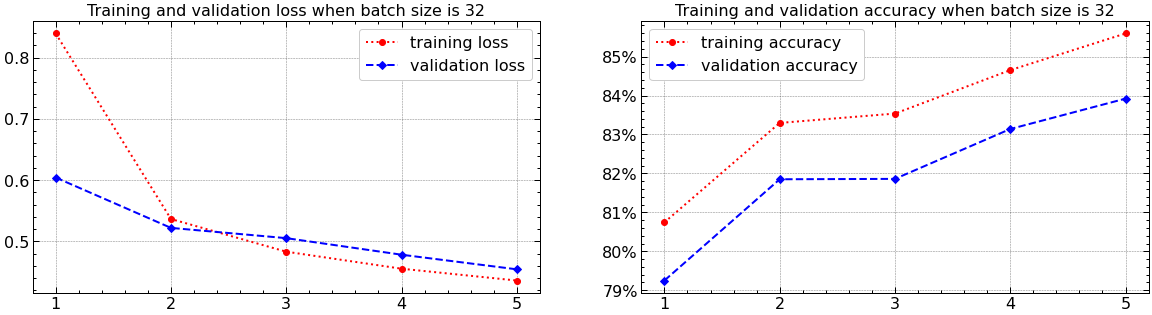

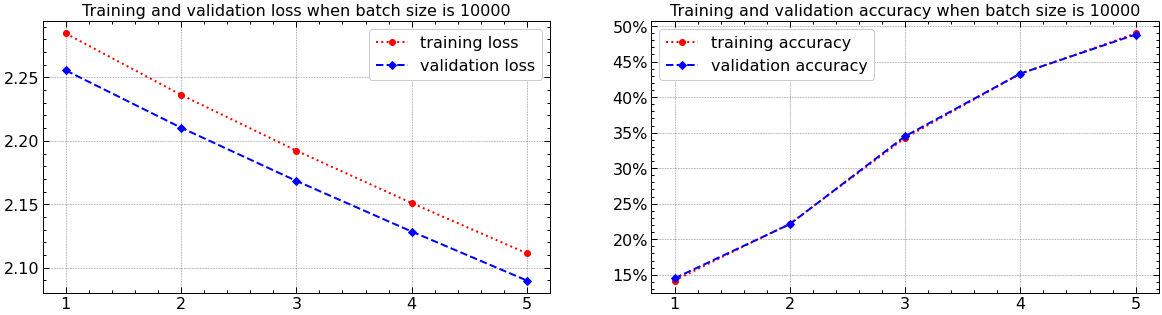

In [44]:
plot_results(batch_32,
             b32_training_losses, b32_training_accuracies, b32_validation_losses, b32_validation_accuracies)

plot_results(batch_10k,
             b10k_training_losses, b10k_training_accuracies, b10k_validation_losses, b10k_validation_accuracies)